In [2]:
from IPython.display import display, Javascript

%store -r the_page
%store -r the_editor
%store -r agg_actions
%store -r editor_inputname
%store -r calculator
%store -r editors_conflicts

if ('the_page' not in locals() or 
    'the_editor' not in locals() or 
    'agg_actions' not in locals() or 
    'editor_inputname' not in locals() or 
    'calculator' not in locals() or 
    'editors_conflicts' not in locals()):
    
    import pickle
    print("Loading default data...")
    the_page = pickle.load(open("data/the_page.p",'rb'))
    the_editor = pickle.load(open("data/the_editor.p",'rb'))
    agg_actions = pickle.load(open("data/agg_actions.p",'rb'))
    editor_inputname = pickle.load(open("data/editor_inputname.p",'rb'))
    calculator = pickle.load(open("data/calculator.p",'rb'))
    editors_conflicts = pickle.load(open("data/editors_conflicts.p",'rb'))

display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

In [3]:
%%html
<style>
summary{
    display:list-item;
}
</style>

In [4]:
%%capture

%load_ext autoreload
%autoreload 2

### <span style="color:green"> Modules Imported </span>

In [5]:
## Modules Imported ##

# Display
from IPython.display import display, Markdown as md, clear_output, Javascript
from datetime import datetime, date

# APIs
from external.wikipedia import WikipediaDV, WikipediaAPI

# Load and process data.
import pickle

# Visualization
import qgrid
from visualization.calculator_listener import ConflictCalculatorListener
from visualization.actions_listener import ActionsListener
from visualization.wordcloud_listener import WCListener

from utils.notebooks import get_date_slider_from_datetime

from ipywidgets import interact, Output, widgets, Layout
from ipywidgets.widgets import Dropdown

# Load the variables stored in the last notebook
%store -r the_page
%store -r total_actions
%store -r conflict_calculator
%store -r conflicts_by_editors
%store -r editor_info
%store -r editor_input_id

# Check them if in the namespace, otherwise load the default data.
if ('the_page' not in locals() or 
    'total_actions' not in locals() or 
    'conflict_calculator' not in locals() or 
    'conflicts_by_editors' not in locals() or
    'editor_info' not in locals() or
    'editor_input_id' not in locals()):
    
    print("Loading default data...")
    the_page = pickle.load(open("data/the_page.p",'rb'))
    total_actions = pickle.load(open("data/agg_actions.p",'rb'))
    conflict_calculator = pickle.load(open("data/calculator.p",'rb'))
    conflicts_by_editors = pickle.load(open("data/editors_conflicts.p",'rb'))
    editor_info = pickle.load(open("data/the_editor.p",'rb'))
    editor_input_id = pickle.load(open("data/editor_inputname.p",'rb'))

---

# A.  Select an editor to analyze their conflicting editors

In [6]:
display(md(f"***Page: {the_page['title']}***"))

***Page: The Camp of the Saints***

The table below presents the conflict score and other related  metrics per editor 
(*editor_id* and *editor* column). Select one editor to analyze the editors that enter into 
conflict with her:

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

- **conflicts**: the total number of conflicts
- **elegibles**: the total number of elegible actions performed by the editor
- **conflict**: the sum of conflict scores of all actions divided by the number of elegible actions
</details>

In [7]:
def display_conflict_score(eleg_actions):
    global listener
    
    
    listener = ConflictCalculatorListener(eleg_actions)

    metrics = ['Conflict Score', 'Absolute Conflict Score', 
               'Conflict Ratio',  'Number of Conflicts', 
               'Total Elegible Actions', 
               'Total Conflict Time', 'Total Elegible Time', 
               'Time per Conflict Action', 'Time per Elegible Action']

    display(md(f'*Total Page conflict score: {calculator.get_page_conflict_score()}*'))

    # Visualization

    interact(listener.listen,
             _range = get_date_slider_from_datetime(eleg_actions['rev_time']),
             granularity=Dropdown(options=['Yearly', 'Monthly', 'Daily'], value='Daily'),
             black=Dropdown(options=metrics, value='Conflict Score'),
             red=Dropdown(options= ['None'] + metrics, value='None'))

def select_editor(editor):
    global editor_df
    global the_editor
    global editor_inputname

    editor_inputname=editor
    
    wikipedia_dv = WikipediaDV(WikipediaAPI(domain='en.wikipedia.org'))
    try:
        the_editor = wikipedia_dv.get_editor(int(editor_inputname))
    except:
        the_editor = wikipedia_dv.get_editor(editor_inputname[2:])

    with out:
        %store the_editor
        %store editor_inputname

        clear_output()
        display(md("### Current Selection:"))
        
        url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_inputname}&usprop=blockinfo|editcount|registration|gender&format=json'
        print("Editor's metadata can be found in:")
        print(url)
        if 'invalid' in the_editor:
            display(f"The editor {editor_inputname} was not found, try a different editor")
        else:
            # display the data that will be passed to the next notebook
            display(the_editor.to_frame('values'))
            display(md(f"#### Evolution of the Conflict Score of *{the_editor['name']}*"))

            editor_df = calculator.elegible_actions[
                calculator.elegible_actions['editor'] == str(editor_inputname)].copy()


            display_conflict_score(editor_df)


def on_selection_change(change):

    try:
        select_editor(qg_obj.get_selected_df().iloc[0].name)
    except:
        print('Problem parsing the name. Execute the cell again and try a different editor.')


qgrid.set_grid_option('maxVisibleRows', 5)
qg_obj = qgrid.show_grid(editors_conflicts)
qg_obj.observe(on_selection_change, names=['_selected_rows'])
                       
display(md("### Select one editor (row) to continue the demo:"))
display(md('**Recomendation:** select an editor with *many conflicts* and *mid-high conflict score*'))
display(qg_obj)
out = Output()
display(out)

select_editor(editor_inputname)

### Select one editor (row) to continue the demo:

**Recomendation:** select an editor with *many conflicts* and *mid-high conflict score*

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Output()

In the above graph you can select the *date range* and *granularity* (yearly, montly) 
of the timeline (X-axis), and plot any of the following counts in the black and red lines:

<details>    
    <summary style="cursor: pointer;font-weight:bold">Options description</summary>
    
- **Conflict Score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **Absolute Conflict Score**: the sum of conflict scores of all actions (without division)
- **Conflict Ratio**: the count of all conflicts divided by the number of elegible actions
- **Number of Conflicts**: the total number of conflicts
- **Total Elegible Actions**: the total number of elegible actions
- **Total Conflict Time**: the sum of all the time (*time_diff_secs*) that has been taken by conflict actions
- **Total Elegible Time**: the sum of all the time (*time_diff_secs*) that has been taken by elegible actions
- **Time per Conflict Action**: average time of conflict actions
- **Time per Elegible Action**: average time of elegible actions
</details>

### <span style="color:green"> TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU SELECT AN EDITOR </span>

In [8]:
### ----------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU SELECT AN EDITOR  ###
### ----------------------------------------------------------------- ###

## This is the page you used ##
print('The page that is being used:', the_page['title'])

## Use the variable from the last notebook: conflicts_by_editors (pd.DataFrame)        ##
## Display the dataframe using interactive grid, you could learn more through the doc: ##
## https://qgrid.readthedocs.io/en/latest/                                             ##
qgrid.set_grid_option('maxVisibleRows', 5)
qgrid_init = qgrid.show_grid(conflicts_by_editors)
display(qgrid_init)

## Get the editor info with Wikipedia API (get_editor() method), more details you could check: ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/api.py                        ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/external/wikipedia.py                  ##
wikipedia_dv = WikipediaDV(WikipediaAPI(domain='en.wikipedia.org'))

# This is an example editor index. You could change it manully by typing in a new index from
# the above grid, e.g. 737021
editor_input_id = 2595305

# Get the editor's information in the form of pd.DataFrame
editor_info = wikipedia_dv.get_editor(int(editor_input_id))

## Display the basic information of the selected editor ##
editor_url = f'{wikipedia_dv.api.base}action=query&list=users&ususerids={editor_input_id}&usprop=blockinfo|editcount|registration|gender&format=json'
print("Editor's metadata can be found in:")
print(editor_url)
display(md("### Current Selection:"))
display(editor_info.to_frame('values'))

## Interactive evolution of conflict score of this editor, using ConflictCalculatorListener, more details see ##
## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/calculator_listener.py                  ##
display(md(f"#### Evolution of the Conflict Score of *{editor_info['name']}*"))

# Dataframe containing the elegible actions info of the editor for interactive.
editor_df = conflict_calculator.elegible_actions[conflict_calculator.elegible_actions['editor'] == str(editor_input_id)].copy()
           
# Create a ConflictCalculatorListener instance.
conflicts_cal_listener = ConflictCalculatorListener(editor_df)

# Set parameters.
begin_date = date(2005, 3, 1)
end_date = date(2019, 6, 1)
frequency = 'Daily' # 'Monthly', 'Daily'

# The metrics we need:
# ['Conflict Score', 'Absolute Conflict Score', 'Conflict Ratio', 'Number of Conflicts',
#  'Total Elegible Actions', 'Total Conflict Time', 'Total Elegible Time', 
# 'Time per Conflict Action', 'Time per Elegible Action', ('None')]
# Note: only 'red_line' has 'None' option.
black_line = 'Conflict Score'
red_line = 'None'
           
print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
print('Total Page conflict score:', conflict_calculator.get_page_conflict_score())
           
conflicts_cal_listener.listen(
    _range = (begin_date, end_date),
    granularity = frequency,
    black = black_line,
    red = red_line
)
           
# store the editor_input_id and editor_info for the usage in next notebook.
%store editor_input_id
%store editor_info

The page that is being used: The Camp of the Saints


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Editor's metadata can be found in:
https://en.wikipedia.org/w/api.php?action=query&list=users&ususerids=2595305&usprop=blockinfo|editcount|registration|gender&format=json


### Current Selection:

,values
userid,2595305
name,P4k
editcount,12157
registration,2006-10-28T03:29:10Z
gender,unknown


#### Evolution of the Conflict Score of *P4k*

Time range from 2005-03-01 to 2019-06-01
Total Page conflict score: 0.8681590556957548


Stored 'editor_input_id' (int)
Stored 'editor_info' (Series)


---

# B. Detecting conflicting editors

In [9]:
display(md(f"***Page: {the_page['title']}***"))

***Page: The Camp of the Saints***

If the editor undo the action of editor B, editor B is called 
a conflicting editor. The following table shows the conflicting editors including their conflict score and other related metrics (see section A).

<details>    
    <summary style="cursor: pointer;font-weight:bold">Columns description</summary>

- **conflict_n**: the total number of conflicts
- **conflict**: the sum of conflict scores of all actions (without division)
- **actions**: the total number of actions performed by the editor
- **conflict_score**: the sum of conflict scores of all actions divided by the number of elegible actions
- **conflict_ratio**: the count of all conflicts divided by the number of elegible actions

In [10]:
# create and display the button
button1 = widgets.Button(description="Show Conflicting Editors", layout=Layout(width='180px'))
display(button1)

def on_click_detect(b):
    global editors
    global conflicting_actions
    with out1:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))

        conflicting_actions = calculator.get_conflicting_actions(str(editor_inputname))

        wikipedia_dv = WikipediaDV(WikipediaAPI(domain='en.wikipedia.org'))

        conflicting_editors = conflicting_actions['editor'].unique().tolist()

        editors = wikipedia_dv.get_editors([int(x) for x in conflicting_editors if x[:2] != '0|'])
        if len(editors) == 0:
            print('There is no other registered conflicting editor. Please try another one!')
        else:
            editors['userid'] = editors['userid'].astype('str')
            full_editors_conflicts = calculator.get_conflict_score_per_editor()
            display(editors[['userid','name','registration']].merge( full_editors_conflicts, 
                            right_index=True, left_on='userid',how='left').set_index('userid'))
                   
                   
out1 = Output()
display(out1)

# set the event
button1.on_click(on_click_detect)

# trigger the event with the default value
on_click_detect(button1)

Button(description='Show Conflicting Editors', layout=Layout(width='180px'), style=ButtonStyle())

Output()

### <span style="color:green"> TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Refresh Conflicting Editors' Button </span>

In [11]:
### ------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Refresh Detected Editors' BUTTON  ###
### ------------------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'])
print('Selected editor:', editor_info['name'])

## Get the conflicting editors ##

# Get all conflcting actions of all editors through the instance 'conflict_calculator'
# created in the second notebook. Use the 'get_conflicting_actions()' method.
all_conflict_actions = conflict_calculator.get_conflicting_actions(str(editor_input_id))

# Get a list of conflicting editors.
all_conflict_editors = all_conflict_actions['editor'].unique().tolist()

# Eliminate the unregistered editors
final_editors = wikipedia_dv.get_editors([int(x) for x in all_conflict_editors if x[:2] != '0|'])

# Check if the conflicting editor's list is empty.
if len(final_editors) == 0:
    print('There is no other registered conflicting editor. Please try another one!')
else:
    final_editors['userid'] = final_editors['userid'].astype('str')
    
    # Conflict score for every editor.
    all_editors_conflicts = conflict_calculator.get_conflict_score_per_editor()
    
    # Integrate conflicting information into the editors' basic info table. 
    display(final_editors[['userid','name','registration']].merge(all_editors_conflicts, 
                             right_index=True, left_on='userid', how='left').set_index('userid'))

The page that is being used: The Camp of the Saints
Selected editor: P4k


,name,registration,conflict_n,conflict,action,conflict_score,conflict_ratio
userid,,,,,,,
85879,User2004,2004-07-13T08:00:40Z,24,23.628624,24,0.984526,1.0


---

# C. Activity of conflicting editors

In [12]:
display(md(f"***Page: {the_page['title']}***"))

***Page: The Camp of the Saints***

In the following graph you can select the conflicting *editor*, *date range* and 
*granularity* (yearly, montly) of the timeline (X-axis), and plot any of the follow counts in 
the black, red, blue and green lines:


<details>    
    <summary style="cursor: pointer;font-weight:bold">Options description</summary>

- **adds**: number of first-time insertions
- **adds_surv_48h**: number of insertions for the first time that survived at least 48 hours
- **adds_persistent**:  number of insertions for the first time that survived until, at least, the end of the month
- **adds_stopword_count**:  number of insertions that were stop words
- **dels**: number of deletions
- **dels_surv_48h**: number of deletions that were not resinserted in the next 48 hours
- **dels_persistent**: number of deletions that were not resinserted until, at least, the end of the month
- **dels_stopword_count**: number of deletions that were stop words
- **reins**: number of reinsertions
- **reins_surv_48h**: number of reinsertionsthat survived at least 48 hours
- **reins_persistent**: number of reinsertionsthat survived until the end of the month
- **reins_stopword_count**: number of reinsertionsthat were stop words

In [13]:
# create and display the button
button2 = widgets.Button(description="Show Conflicting Editors Activities", layout=Layout(width='230px'))
display(button2)

def on_click_con_editor_act(b):
    global editors
    with out2:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))
        if len(editors) == 0:
            print('There is no other registered conflicting editor. Please try another one!')
        else:
            editors['userid'] = editors['userid'].astype('int')
            conf_editor_agg_actions = editors[['userid','name','registration']].merge(agg_actions, 
                     left_on='userid', right_on='editor_id', how='left').set_index('userid')

            # Listener
            listener = ActionsListener(conf_editor_agg_actions)
            actions = (conf_editor_agg_actions.loc[:,'total':'total_stopword_count'].columns.append(
                conf_editor_agg_actions.loc[:,'adds':'reins_stopword_count'].columns)).values.tolist()

            # Visualization
            interact(listener.listen, 
                     _range = get_date_slider_from_datetime(conf_editor_agg_actions['year_month']),
                     editor=Dropdown(options=['All'] + editors['name'].values.tolist(), value='All'),
                     granularity=Dropdown(options=['Yearly', 'Monthly'], value='Monthly'),
                     black=Dropdown(options=actions, value='total'), 
                     red=Dropdown(options= ['None'] + actions, value='total_surv_48h'),
                     green=Dropdown(options= ['None'] + actions, value='None'), 
                     blue=Dropdown(options= ['None'] + actions, value='None'))

out2 = Output()
display(out2)

# set the event
button2.on_click(on_click_con_editor_act)

# trigger the event with the default value
on_click_con_editor_act(button2)

Button(description='Show Conflicting Editors Activities', layout=Layout(width='230px'), style=ButtonStyle())

Output()

### <span style="color:green"> TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Refresh Conflicting Editors Activities' Button </span>

In [14]:
### ----------------------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Refresh Conflicting Editors Activities' BUTTON ###
### ----------------------------------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'])
print('Selected editor:', editor_info['name'])

## First check if the list is empty. ##
if len(final_editors) == 0:
    print('There is no other registered conflicting editor. Please try another one!')
else:
    print('Available Conflicting Editors:', final_editors['name'].tolist())
    
    ## Merge editors' total actions information into 'final_editors' table. ##
    final_editors['userid'] = final_editors['userid'].astype('int')
    conf_editor_total_actions = final_editors[['userid','name','registration']].merge(total_actions, 
                                             left_on='userid', right_on='editor_id', how='left').set_index('userid')
    
    ## Visualization, core visual code lies in ActionsListener, then the interact function    ##
    ## make it interactive, mode details see:                                                 ##
    ## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/actions_listener.py ##
    
    # Create an ActionsListener instance.
    actionslistener = ActionsListener(conf_editor_total_actions)
    
    # What types of these actions?
    actions_types = (conf_editor_total_actions.loc[:,'total':'total_stopword_count'].columns.append(
                        conf_editor_total_actions.loc[:,'adds':'reins_stopword_count'].columns)).values.tolist()
    
    # Visualization: try yourself by coding!
    begin_date = date(2002, 3, 1)
    end_date = date(2019, 4, 1)
    editor_name = 'All' # Select one conflicting name from the above name list, or 'All'!
    frequency = 'Monthly' # 'Yearly', 'Monthly'
    black_line = 'adds' # Choose one from 'actions_types'. Note that 'black_line doesn't have 'None' option but others have.
    red_line = 'dels'
    blue_line = 'None'
    green_line = 'None'
    
    print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
    print("Current editor's name is", editor_name)
    
    actionslistener.listen(
        _range = (begin_date, end_date),
        editor = editor_name,
        granularity = frequency,
        black = black_line,
        red = red_line,
        blue = blue_line,
        green = green_line)

The page that is being used: The Camp of the Saints
Selected editor: P4k
Available Conflicting Editors: ['User2004']
Time range from 2002-03-01 to 2019-04-01
Current editor's name is All


---

# D. Tokens of conflicting editors

In [15]:
display(md(f"***Page: {the_page['title']}***"))

***Page: The Camp of the Saints***

The WordCloud displays the most common token strings (words) that a particular editor 
inserted or deleted and that enter into conflict with other editors. The size of the token string in 
the WordCloud indicates frequency of actions.

In the controls, you can select the conflicting *editor*, the *date range*, the type of *action* 
(insertion or deletion), and the *source*.


<details>    
    <summary style="cursor: pointer;font-weight:bold">Source description</summary>
    
-   **Only Conflicts**: use only the actions that are in conflict
-   **All Undos**: use all actions that involve and undo <mark> *Question: Should it be "Elegible Actions?"* </mark>
</details>

In [16]:
# create and display the button
button3 = widgets.Button(description="Show Tokens of Conflicting Editors", layout=Layout(width='250px'))
display(button3)

def on_click_token_conflict(b):
    with out3:
        clear_output()
        display(md(f"***Editor: {the_editor['name']}***"))
        
        if len(editors) == 0:
           print('Thallere is no other registered conflicting editor. Please try another one!')
        else:      
            editors['userid'] = editors['userid'].astype('str')
            editor_conflicts = editors[['userid','name','registration']].merge(conflicting_actions, 
                     left_on='userid', right_on='editor', how='left').set_index('userid')
            sources = {
                f'Elegible Actions': editor_conflicts,
                f'Only Conflicts': editor_conflicts[~editor_conflicts['conflict'].isnull()]
            }

            # listener
            listener = WCListener(sources)

            # visualization
            interact(listener.listen, 
                     _range=get_date_slider_from_datetime(editor_conflicts['rev_time']),
                     editor=Dropdown(options=['All']  + editors['name'].values.tolist(), value='All', layout={'width': '400px'}),
                     source=Dropdown(options=list(listener.sources.keys()), value= f'Elegible Actions', layout={'width': '400px'}),
                     action=Dropdown(options=['Both', 'Just Insertions', 'Just Deletions'], value='Both', layout={'width': '400px'}))

out3 = Output()
display(out3)

# set the event
button3.on_click(on_click_token_conflict)

# trigger the event with the default value
on_click_token_conflict(button3)

Button(description='Show Tokens of Conflicting Editors', layout=Layout(width='250px'), style=ButtonStyle())

Output()

### <span style="color:green"> TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Refresh Tokens of Conflicting Editors' Button </span>

The page that is being used: The Camp of the Saints
Selected editor: P4k
Available Conflicting Editors: ['User2004']
Time range from 2005-03-01 to 2019-07-04
Current editor's name is All


**Only top 100 most frequent words displayed.**

### The below token conflicts ocurred in a total of 1 revisions:

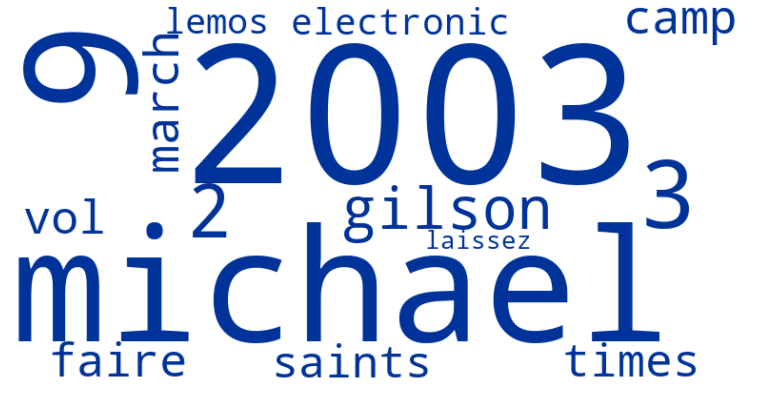

In [17]:
### ---------------------------------------------------------------------------------------------------- ###
### TRY YOURSELF! THIS IS WHAT WILL HAPPEN WHEN YOU CLICK 'Refresh Tokens of Conflicting Editors' BUTTON ###
### ---------------------------------------------------------------------------------------------------- ###

## This is the page you used and the editor you select in the above grid. ##
print('The page that is being used:', the_page['title'])
print('Selected editor:', editor_info['name'])

## First check if the list is empty. ##
if len(final_editors) == 0:
    print('There is no other registered conflicting editor. Please try another one!')
else:
    print('Available Conflicting Editors:', final_editors['name'].tolist())
    
    ## Integrate conflict tokens info into editors' basic information table. ##
    final_editors['userid'] = final_editors['userid'].astype('str')
    editor_in_conflicts = final_editors[['userid','name','registration']].merge(all_conflict_actions, 
                             left_on='userid', right_on='editor', how='left').set_index('userid')
    
    ## WordCloud, core visual code lies in WCListener, then the interact function               ##
    ## make it interactive, mode details see:                                                   ##
    ## https://github.com/gesiscss/wikiwho_demo/blob/master/visualization/wordcloud_listener.py ##
    
    # Define the token sources.
    wcsources = {
    f'Elegible Actions': editor_in_conflicts,
    f'Only Conflicts': editor_in_conflicts[~editor_in_conflicts['conflict'].isnull()]}

    # Create a WCListener instance
    wclistener = WCListener(wcsources)
    
    # Visualization: you could also perform it by coding!
    begin_date = date(2005, 3, 1)
    end_date = date(2019, 7, 4)
    editor='All' # Select one conflicting name from the above name list, or 'All'!
    actions_source='Only Conflicts' # 'Elegible Actions', 'Only Conflicts'
    action_type='Both' # 'Just Insertions', 'Just Deletions', 'Both'
    
    print('Time range from', begin_date.strftime("%Y-%m-%d"), 'to', end_date.strftime("%Y-%m-%d"))
    print("Current editor's name is", editor)
    
    wclistener.listen(
         _range=(begin_date, end_date),
         source=actions_source,
         action=action_type,
         editor=editor)

In [19]:
from IPython.display import HTML
from utils.notebooks import get_next_notebook

display(HTML(f'<a href="{get_next_notebook()}" target="_blank">Go to next workbook</a>'))

scroll_to_top = """
<script>
document.getElementById('notebook').scrollIntoView();
</script
"""
display(HTML(scroll_to_top))